# Tarea 3: Regularización y Optimización <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Rodrigo Urrea Loyola

**Fecha de entrega: 13 de noviembre de 2020**


In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-3oh8u9c1/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-3oh8u9c1/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5801 sha256=6b0567cee05780b68a74f5f65911ac58b6a4b48793ff4eb66bbaedb352c5754a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lijck6w7/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
  Found existing installation: cc6204 0.5.0
    Uninstalling cc6204-0.5.0:
      Successfully uninstalled cc6204-0.5.0


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Regularización y Generalización



## 1a) Regularización por *weight decay*

In [ ]:
# Tu código debiera comenzar así
class SGD():
  def __init__(self, parameters, lr, beta=0):
    self.parameters=[p for p in parameters if p is not None]
    self.lr=lr
    self.beta=beta
  
  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    for parametro in self.parameters:
      parametro.data = parametro.data*(1 - self.beta) - self.lr * parametro.grad

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="1a", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, beta=0.1)
optimizer.step()

# Submit
corrector.submit(homework=3, question="1a", test=1, token=token, answer=weight)

Using cached test data
Correct Test!


## 1b) Regularización por dropout

Para esta parte de la tarea, va a ser necesario modificar el método `forward` para que entregue el valor a la salida de la i-esima capa escondida. Para esto se modifica el método forward para que reciba un parámetro `output_layer` que indica luego de que capa escondida se espera el output.

In [ ]:
# Tu código debiera continuar como sigue

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C,keep_prob):
    super(FFNN, self).__init__()
    #pasamos todos los parametros a torch.nn.Parameter(), y definimos las variables de los parametros (pesos) y los sesgos de la red
    self.F= F
    self.l_h= l_h
    self.l_a=l_a
    self.C= C
    sizes = [F] + l_h + [C]
    self.parametros = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.sesgos = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.probs = keep_prob

  def setParameters(self,W,b,U,c):
    #incializamos o modificamos los parametros y sesgos de la red, juntamos W con U y b con c
    self.parametros=torch.nn.ParameterList([torch.nn.Parameter(W[i]) for i in range(len(W))]+[torch.nn.Parameter(U)])
    self.sesgos=torch.nn.ParameterList([torch.nn.Parameter(b[i]) for i in range(len(b))]+[torch.nn.Parameter(c)])

  def resumen(self):
    # Usa self.named_parameters(). y retorna todos los parametros reconocidos de la neurona
    for param in self.named_parameters():
      print(param)
      pass
  

  def forward(self, x, output_layer ,predict=False):
    # Usa los parámetros y funciones de activación.
    # Retorna y = softmax(capa_de_salida).
    device = x.device.type

    # Funcion para resumir codigo de creacion y aplicacion de las mascara para dropout
    def creacion_mascara(h,predict,device,probs):
      if not predict:
        Mask = torch.rand(h.data.size(1)).to(device)
        Mask = (Mask<=probs)*1
        Mask = Mask/probs
        return h.data*Mask,Mask
      else:
        Mask = torch.ones_like(h.data).to(device)
        return h.data,Mask

    #Parametros que nos serviran para backward(), se renuevan cada vez que se hace un forward
    self.cache_h=[]
    self.cache_u=[]
    self.mask=[]

    x,Mask = creacion_mascara(x.data,predict,device,self.probs[0])
    self.mask.append(Mask)
    self.cache_h.append(x)

    # Checkeo de out_layer, si esta en 0 significa que debemos sacar la info de esta capa
    if output_layer == 0:
      return x.data
    output_layer -= 1

    u=torch.add(torch.mm(x.data,self.parametros[0]),self.sesgos[0])
    self.cache_u.append(u)
    #inicializamos h con (la primera multiplicacion entre x y W1) + b1
    h=self.l_a[0](u.data) 

    h,Mask = creacion_mascara(h.data,predict,device,self.probs[1])   
    self.mask.append(Mask)                                                  
    self.cache_h.append(h)

    if output_layer == 0:
      return h.data
    output_layer -= 1  

    #recorremos todos los parametros (todas las matrices de peso), excepto la ultima
    for i in range(1,len(self.sesgos)-1):                                       
      u=torch.add(torch.mm(h.data,self.parametros[i]),self.sesgos[i])
      self.cache_u.append(u)
      #redefinimos h como vimos en clases
      h=self.l_a[i](u.data)

      h,Mask = creacion_mascara(h.data,predict,device,self.probs[i+1])
      self.mask.append(Mask)                                                          
      self.cache_h.append(h)

      if output_layer == 0:
        return h.data
      output_layer -= 1

    u=torch.add(torch.mm(h.data,self.parametros[-1]),self.sesgos[-1])
    self.cache_u.append(u)

    #return softmax(u,1)#devolvemos softmax de los predicho por nuestra red (y)
    return softmax(u.data,1)

  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    # Computar acá todos los gradientes con respecto a L
    # Hint: Los gradientes deben quedar almacenados en 
    #       el atributo `grad` para cada parámetro.
    #       Más info sobre este atributo en
    #       https://pytorch.org/docs/stable/autograd.html#torch.Tensor.grad

    N=x.size()[0]
    #se utilizan los h y u calculado en el paso forward
    h=self.cache_h
    u=self.cache_u  

    #se calculan las derivadas con la formula obtenida de la derivacion a mano

    u_grad=(1/N)*(y_pred.data-y.data)
    self.parametros[-1].grad = (torch.transpose(h[-1].data,dim0=0,dim1=1)) @ u_grad.data
    self.sesgos[-1].grad = torch.reshape(torch.sum(u_grad.data,dim=0,keepdim=True),self.sesgos[-1].data.size())
    for i in range (1,len(self.parametros)):
      #dropout
      h_grad = u_grad.data @ (torch.transpose(self.parametros[-i].data,dim0=0,dim1=1))


      u_grad = h_grad.data * self.l_a[-i](u[-i-1].data,gradient=True)*self.mask[-i]
      self.parametros[-i-1].grad = (torch.transpose(h[-i-1].data,dim0=0,dim1=1)) @ u_grad.data
      self.sesgos[-i-1].grad = torch.reshape(torch.sum(u_grad.data,dim=0,keepdim=True),self.sesgos[-i-1].data.size())
    return

In [ ]:
#Funciones Tarea 2
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def relu(T, gradient=False):
  if gradient:
    return torch.where(T>0,torch.ones_like(T),torch.zeros_like(T))
  return torch.where(T>0,T,torch.zeros_like(T))

def softmax(T, dim, estable=True):
  if estable:                                #esto es que queremos restar el mismo valor por cada componente de la dimension dim
    aux=torch.max(T,dim=dim,keepdim=True)[0] #aqui construimos un arreglo auxiliar con las "mismas dimensiones" que T 
    aux=torch.exp(torch.sub(T,aux))          #(tiene un 1 en la dimension dim) y guarda los maximos por componente en esa dimension de T
                                             #luego se le resta ese maximo a cada componente (siempre a la correspondiente) y saca exp
  else:                                      #estable=false, por lo que no restamos nada
    aux=torch.exp(T)                         #solo tomamos exp
  return torch.div(aux,torch.sum(aux,dim,keepdim=True))  #devolvemos la division entre la componente y la suma en dicha dimension

def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta  
  #        (mediante matrices con las mismas dimensiones)
  # estable y epsilon: nos permiten lograr estabilidad numérica cuando 
  #       intentamos computar el logaritmo de valores muy pequeños.
  #       epsilon limitará el valor mínimo del valor original cuando estable=True
  N=P.size()[0]
  if estable:
    Qaux=Q.clamp(epsilon,1-epsilon)
  else:
    Qaux=Q
  T=-1*P*torch.log(Qaux)
  return (1/N)*torch.sum(T)

In [ ]:
# Tests del API del curso
torch.manual_seed(0)
sample = torch.rand(1, 10)
red = FFNN(10, [1000], [sig], 1, keep_prob=[1.0,0.5])
y = red(sample, output_layer=1)
output_mask = (y == 0)

percent = torch.sum(output_mask).item() / list(output_mask.size())[-1]
print(percent)
# Submit
corrector.submit(homework=3, question="1b", test=1, token=token, answer=percent)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


0.528
Correct Test!


## 1c) Entrenamiento y generalización sobre MNIST 

In [ ]:
# Aqui el codigo para entrenar en MNIST
# Importamos MNIST desde torchvision.
from torchvision.datasets import MNIST

# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
train_dataset = MNIST('mnist', train=True, transform=ToTensor(),download=True)
print('Cantidad total de datos:',len(train_dataset))
test_dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(test_dataset))

Cantidad total de datos: 60000
Cantidad total de datos: 10000


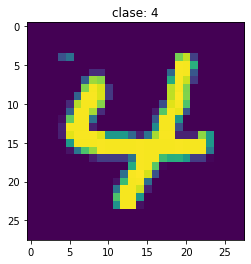

In [ ]:
#Probamos que se haya cargado el dataset
import random
import matplotlib.pyplot as plt
index = random.randint(0,len(train_dataset))               #obtenemos imagen al azar del dataset
T, l = train_dataset[index]                                #guardamos el vector de features (T) y su categoria (l)
numero = T.view(28,28).numpy()                       #modificamos la imagen para plotearla mas facil
fig1 = plt.imshow(numero)                            #plot de la imagen
plt.title("clase: "+ str(l))                         #titulo de la imagen
plt.show()

In [123]:
import sys
from torch.utils.data import DataLoader
# Tu código acá
def entrenar_FFNN(red, dataset,test_dataset, optimizador, epochs=1, batch_size=1, device='cuda',reports_every=1):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset,batch_size)

  # Comienza el entrenamiento
  loss, acc = [], []
  loss_test,acc_test = [], []
  N = len(dataset)
  for e in range(1,epochs+1):
    L_total = 0
    correctos = 0

    for x, y in data:
      x = x.to(device)
      y = y.to(device)
      x = x.view(batch_size,-1)
      y_pred=red.forward(x,output_layer=(len(red.l_h)+2))
      y_pred.to(device)
      #y_mod es un tensor de 2 dim con 0 en todos los lugares menos en el espacio de su clase (se hace esta transformacion
      # para que calcen las dimensiones con el y_pred obtenido de forward)
      y = torch.tensor(y)
      y_mod = torch.nn.functional.one_hot(y,red.C).float()
      y_mod.to(device)
      L_total += CELoss(y_pred, y_mod)
      red.backward(x,y_mod,y_pred)
      optimizador.step()
      #se obtiene el argmax de y_pred para que calce con el vector de clases y
      y_pred=torch.argmax(y_pred,dim=1)
      y_pred.to(device)
      correctos += torch.sum(y_pred == y).item()
    
    # Reporta el acierto cada "reports_every" cantidad de épocas
    if e % reports_every == 0:
      
      L=L_total / len(data)
      loss.append(L)
      accuracy = (correctos / N) * 100
      acc.append(accuracy)

      #De aqui calculamos la loss y el acc para el se de entramiento
      X_test = test_dataset.data.view(len(test_dataset), -1).float().to(device)
      Y_test = test_dataset.targets.to(device)
      Y_test_pred = red.forward(X_test,output_layer=(len(red.l_h)+2),predict = True).to(device)
      Y_test=torch.tensor(Y_test)
      Y_test_mod = torch.nn.functional.one_hot(Y_test,red.C).float()
      Y_test_mod.to(device)
      #Calculo y guardo la loss del test
      loss_epoca = CELoss(Y_test_pred, Y_test_mod)
      loss_test.append(loss_epoca)
                       
      Y_test_pred = torch.argmax(Y_test_pred,dim=1)
      Y_test_pred.to(device)
      correctos_test = torch.sum(Y_test_pred == Y_test).item()
      #Calculo y guardo la acc del test
      acc_epoca=(correctos_test / len(test_dataset)) * 100
      acc_test.append(acc_epoca)

      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(accuracy)
            + ' Loss:{0:.4f}'.format(L) )

  return loss, acc,loss_test,acc_test

In [124]:
def testear_FFNN(red, dataset,batch_size, device='cuda'):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset,batch_size)

  # Comienza el entrenamiento
  loss, acc = [], []
 
  N = len(dataset)
  correctos = 0

  for x, y in data:
      x = x.to(device)
      y = y.to(device)

      x = x.view(batch_size,-1)
      y_pred=red.forward(x,predict=True,output_layer=(len(red.l_h)+2))
      y_pred.to(device)

      #y_mod es un tensor de 2 dim con 0 en todos los lugares menos en el espacio de su clase (se hace esta transformacion
      # para que calcen las dimensiones con el y_pred obtenido de forward)
      y = torch.tensor(y)
      y_mod = torch.nn.functional.one_hot(y,red.C).float()
      y_mod.to(device)

      y_pred=torch.argmax(y_pred,dim=1)
      y_pred.to(device)
      correctos += torch.sum(y_pred == y).item()

    
  acc = (correctos / N) * 100

  return acc

In [125]:
def plot_results(loss, acc, loss_test, acc_test):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r',label="Train")
  ax1.plot(loss_test, c='g',label="Test")
  f1.legend(loc='upper right')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b',label="Train")
  ax2.plot(acc_test, c='y',label="Test")
  f2.legend(loc='lower right')
  f2.show()

In [ ]:
#red "normal"
F , C = 784 , 10
model = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1])
optimizer = SGD(list(model.parameters()),0.001)
with torch.no_grad():
  loss,acc,loss_test,acc_test = entrenar_FFNN(model,train_dataset,test_dataset,optimizer,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:95.89% Loss:0.5590

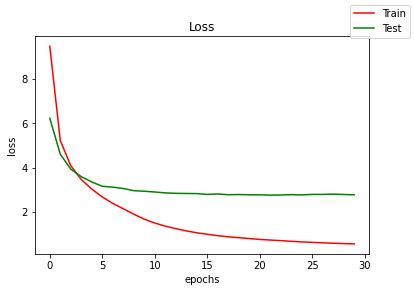

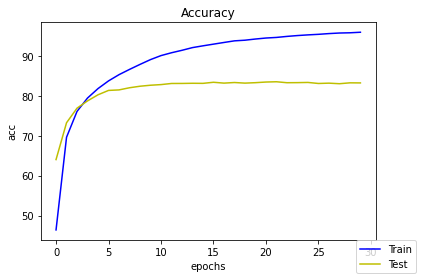

In [ ]:
#Graficos para un red normal sin regularización y con un entrenamiento de 30 epocas
plot_results(loss,acc,loss_test,acc_test)

In [ ]:
#prueba red normal
acc_test = testear_FFNN(model,test_dataset,batch_size=100,device="cuda")
print(acc_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


83.49


Con los graficos y el resultado anterior podemos ver que una red sin ningun tipo de regularización pasa por un proceso de overfitting, que hace que la loss al entrenar sea muy baja y que la acc sea muy alta, pero que al momento de testear frente a nuevos ejemplos, se ve como esos resultados obtenidos anteriormente no reflejan la realidad, y se obtiene valores mas altos de loss y valores mas bajos de precision, lo que aqui ocurre es que en cierta medida la red empieza a ajustarse demasiado a los ejemplos de entrenamiento, lo que hace que pierda generalidad en sus predicciones.

In [ ]:
#red "normal" pero con varias epocas
F , C = 784 , 10
model_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1])
optimizer_e = SGD(list(model_e.parameters()),0.001)
with torch.no_grad():
  loss_e,acc_e,loss_test_e,acc_test_e = entrenar_FFNN(model_e,train_dataset,test_dataset,optimizer_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:97.90% Loss:0.2835

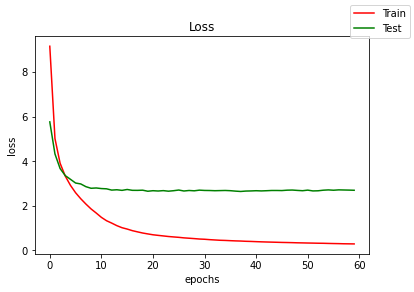

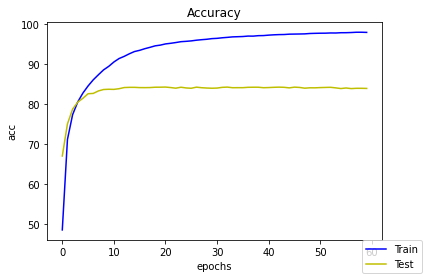

In [ ]:
#Graficos para un red normal sin regularización y con un entrenamiento de 60 epocas
plot_results(loss_e,acc_e,loss_test_e,acc_test_e)

In [ ]:
#prueba red normal con varias epocas
acc_test_e = testear_FFNN(model_e,test_dataset,batch_size=100,device="cuda")
print(acc_test_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


84.32


Podemos ver que no importa mucho si aumentamos las epocas, el resultado se mantiene y esta brecha entre la loss y la acc entre el dataset de entrenamiento y testeo no tiende a cerrarse.

Para tratar de solucionar este problema y conseguir que nuestra red tienda a producir una buena generalizacion, ocuparemos 2 tecnicas de regularazion y analizaremos sus efectos.

In [ ]:
#red regularizada solo con weight decay
F , C = 784 , 10
model2 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1])
optimizer2 = SGD(list(model2.parameters()),lr=0.001,beta=0.0001)
with torch.no_grad():
  loss2,acc2,loss_test2,acc_test2 = entrenar_FFNN(model2,train_dataset,test_dataset,optimizer2,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:92.55% Loss:0.2437

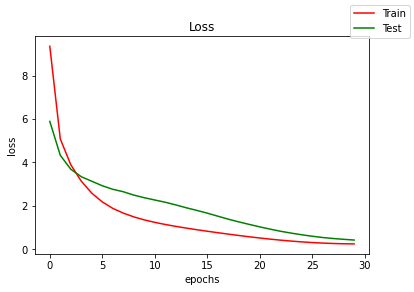

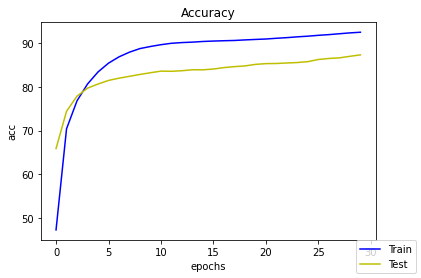

In [ ]:
#Graficos para un red con regularización weigth decay y con un entrenamiento de 30 epocas
plot_results(loss2,acc2,loss_test2,acc_test2)

In [ ]:
#prueba red regularizada
acc_test2 = testear_FFNN(model2,test_dataset,batch_size=100,device="cuda")
print(acc_test2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


91.38


De los resultados anteriores podemos ver como hemos solucionado totalmente el problema que teniamos, hemos conseguido aumentar notablemente nuestra precision al momento de testear y dismuir nuestra loss. Podemos que estamos logrando lo que se buscaba al regularizar, que es el lograr que la loss del train y el test esten lo mas cerca posible (ya teniendo una loss del train bastante bajo). Que sucedera si aumentamos las epocas?

In [ ]:
#red regularizada solo con weight decay con varias epocas
F , C = 784 , 10
model2_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1])
optimizer2_e = SGD(list(model2_e.parameters()),lr=0.001,beta=0.0001)
with torch.no_grad():
  loss2_e,acc2_e,loss_test2_e,acc_test2_e = entrenar_FFNN(model2_e,train_dataset,test_dataset,optimizer2_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:82.54% Loss:1.1766

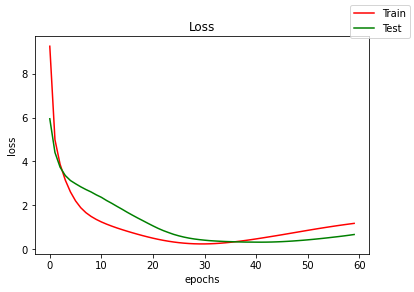

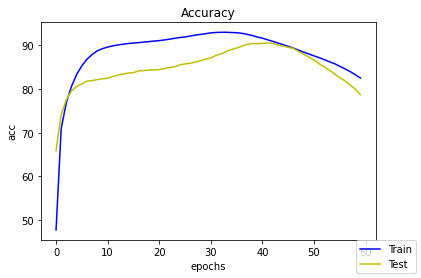

In [ ]:
#Graficos para un red con regularización weigth decay y con un entrenamiento de 60 epocas
plot_results(loss2_e,acc2_e,loss_test2_e,acc_test2_e)

In [ ]:
#prueba red regularizada con varias epocas
acc_test2_e = testear_FFNN(model2_e,test_dataset,batch_size=100,device="cuda")
print(acc_test2_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


82.80999999999999


Como vemos en el grafico el aumentar las epocas no ayudo y mas bien perjudico el aprendizaje, llevo a una desestabilizacion del aprendizaje que llevo a un retroceso con respecto a lo que se habia logrado en menos epocas. Una posible explicacion de este suceso es que a medida avanza en las epocas, la red se va acercando cada vez a su optimo, lo que lleva a que el gradiente se vaya haciendo cada vez menos pronunciado, lo que lleva a que la red varie muy poco sus parametros, a esto se le debe agregar que en cada paso del SGD, se van achicando los parametros en 1-$\beta$ lo que no se ve compensado con la poca variacion que produce el gradiente, esto lleva a que parametros se hagan cada vez mas pequeños y se vayan lentamente alejando del optimo.

In [111]:
#red regularizada solo con dropout 
F , C = 784 , 10
model3 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,0.8,0.8,1])
optimizer3 = SGD(list(model3.parameters()),lr=0.001)
with torch.no_grad():
  loss3,acc3,loss_test3,acc_test3 = entrenar_FFNN(model3,train_dataset,test_dataset,optimizer3,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:77.72% Loss:3.5578

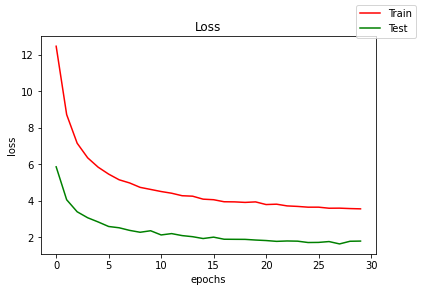

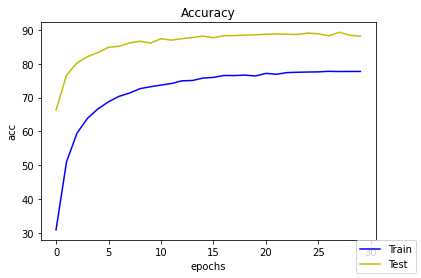

In [112]:
#Graficos para un red con regularización dropout y con un entrenamiento de 30 epocas
plot_results(loss3,acc3,loss_test3,acc_test3)

In [113]:
#prueba red regularizada solo con dropout
acc_test3 = testear_FFNN(model3,test_dataset,batch_size=100,device="cuda")
print(acc_test3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


88.22


Al ver los resultados nos damos cuenta que ocurre algo muy curioso, esto es que tanto la loss como la acc en el test dataset son "mejores" que en el train dataset, aunque estemos entrenando la red como el train dataset, pero esto ocurre porque el dropout consiste en apagar algunas neuronas al azar, lo que lleva a una constante variacion del modelo de entrenamiento, esto es que lleva a una mejor generalizacion de la red, pero hace que al momento de testear sea muy dificil para red obtener buenos niveles de loss y acc, pues dismunye su capacidad y debe entrenar "varios modelos" de forma simultanea. Aun asi, de esta forma obtenemos resultados casi tan buenos como al usar weight decay (aproximadamente 2\% menos de acc). Que pasara si entrenamos la red con mas epocas?

In [ ]:
#red regularizada solo con dropout con varias epocas
F , C = 784 , 10
model3_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,0.8,0.8,1])
optimizer3_e = SGD(list(model3_e.parameters()),lr=0.001)
with torch.no_grad():
  loss3_e,acc3_e,loss_test3_e,acc_test3_e = entrenar_FFNN(model3_e,train_dataset,test_dataset,optimizer3_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:76.34% Loss:2.9099

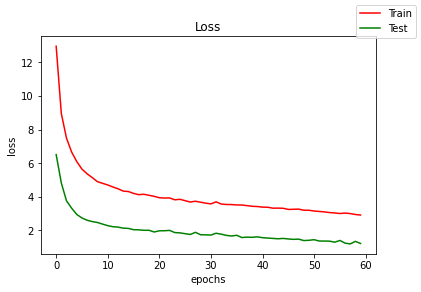

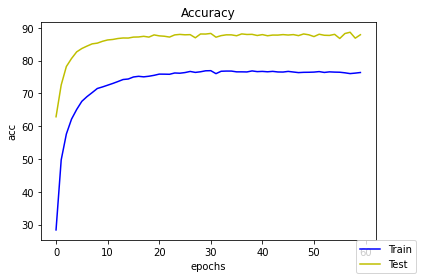

In [ ]:
#Graficos para un red con regularización dropout y con un entrenamiento de 60 epocas
plot_results(loss3_e,acc3_e,loss_test3_e,acc_test3_e)

In [ ]:
#prueba red regularizada solo con dropout con varias epocas
acc_test3_e = testear_FFNN(model3_e,test_dataset,batch_size=100,device="cuda")
print(acc_test3_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


87.9


Podemos ver en los graficos que si bien ocurre algo parecido que con weight decay, que es que al aumentar las epocas emporamos el aprendizaje, este se mantiene muchos mas constante que en el caso anterior, pues solo disminuye un 2%, este error se puede deber a las pequeñas oscilaciones que se observan en el grafico, mas que a un real empeoramiento del aprendizaje. Las razones de estas oscilaciones pueden deberse a pequeños momentos de sobreajuste que sufre la red que luego son corregidos por el dropout.

Ahora que hemos visto que ambas tecnicas nos ayudan bastante a resolver nuestro problema, que ocurrira si las mezclamos?

In [ ]:
#red regularizada con weigth decay y dropout
F , C = 784 , 10
model4 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,0.8,0.8,1])
optimizer4 = SGD(list(model4.parameters()),lr=0.001,beta=0.0001)
with torch.no_grad():
  loss4,acc4,loss_test4,acc_test4 = entrenar_FFNN(model4,train_dataset,test_dataset,optimizer4,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:82.77% Loss:0.5427

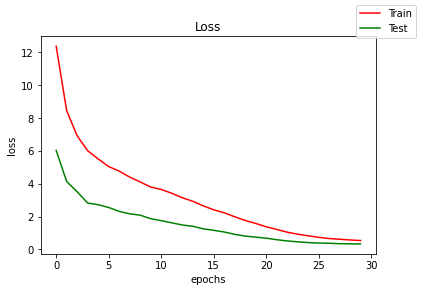

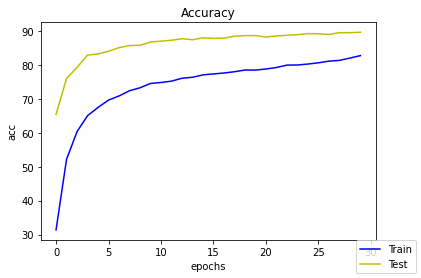

In [ ]:
#Graficos para un red con regularización weight decay y dropout, y con un entrenamiento de 30 epocas
plot_results(loss4,acc4,loss_test4,acc_test4)

In [ ]:
#prueba red regularizada con weight decay y dropout 
acc_test4 = testear_FFNN(model4,test_dataset,batch_size=100,device="cuda")
print(acc_test4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


90.56


Podemos ver que si bien obtuvimos unos buenos resultados, estos no son mejores que los ya obtenidos por los metodos por separado, lo que nos lleva a pensar que no es muy util el combinar ambos metodos. Pero esto mejorara si aumentamos las epocas?

In [ ]:
#red regularizada con weigth decay y dropout con varias epocas
F , C = 784 , 10
model4_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,0.8,0.8,1])
optimizer4_e = SGD(list(model4_e.parameters()),lr=0.001,beta=0.0001)
with torch.no_grad():
  loss4_e,acc4_e,loss_test4_e,acc_test4_e = entrenar_FFNN(model4_e,train_dataset,test_dataset,optimizer4_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:74.82% Loss:1.2394

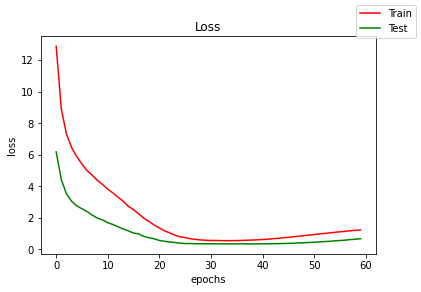

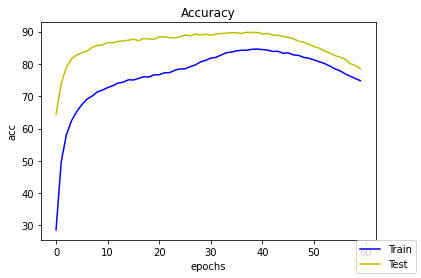

In [ ]:
#Graficos para un red con regularización weight decay y dropout, y con un entrenamiento de 60 epocas
plot_results(loss4_e,acc4_e,loss_test4_e,acc_test4_e)

In [ ]:
#prueba red regularizada con weight decay y dropout con varias epocas
acc_test4_e = testear_FFNN(model4_e,test_dataset,batch_size=100,device="cuda")
print(acc_test4_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


81.91000000000001


Podemos ver que ocurre algo parecido a lo que ocurria con el weight decay solo, pero al estar junto con el dropout no es tan drastico el empeoramiento del aprendizaje.

A modo de conclusion podemos ver que tanto el weight decay como el dropout son herramientas muy poderosas que logran mejorar enormemente el apredizaje y particularmente la generalizacion de la red, que es el poder dar buenos errores de acierto frente a nuevas pruebas.

In [ ]:
import matplotlib.pyplot as plt
epochs_50=[i for i in range(1,51)]
epochs_100=[i for i in range(1,101)]
epochs_200=[i for i in range(1,201)]

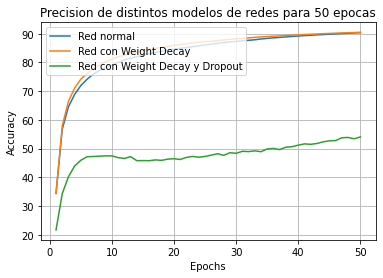

In [ ]:
p1a = plt.plot(epochs_50,acc, label="Red normal")
p2a = plt.plot(epochs_50,acc2, label="Red con Weight Decay")
#p3a = plt.plot(epochs_50,acc3, label="Red con Dropout")
p4a = plt.plot(epochs_50,acc4, label="Red con Weight Decay y Dropout")

plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Precision de distintos modelos de redes para 50 epocas')
plt.grid()
plt.show()

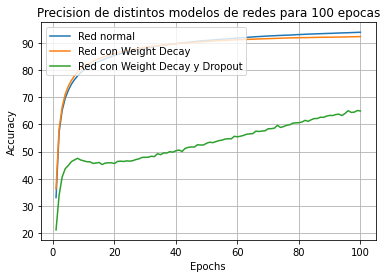

In [ ]:
p1a_e = plt.plot(epochs_100,acc_e, label="Red normal")
p2a_e = plt.plot(epochs_100,acc2_e, label="Red con Weight Decay")
#p3a_e = plt.plot(epochs_40,acc3_e, label="Red con Dropout")
p4a_e = plt.plot(epochs_100,acc4_e, label="Red con Weight Decay y Dropout")

plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Precision de distintos modelos de redes para 100 epocas')
plt.grid()
plt.show()

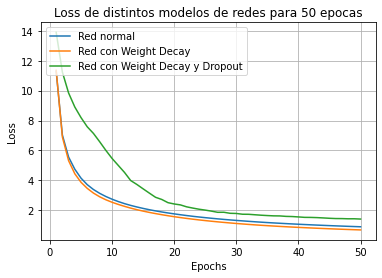

In [ ]:
p1l = plt.plot(epochs_50,loss, label="Red normal")
p2l = plt.plot(epochs_50,loss2, label="Red con Weight Decay")
#p3l = plt.plot(epochs_20,loss3, label="Red con Dropout")
p4l = plt.plot(epochs_50,loss4, label="Red con Weight Decay y Dropout")

plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss de distintos modelos de redes para 50 epocas')
plt.grid()
plt.show()

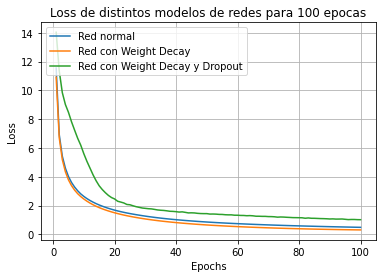

In [ ]:
p1l_e = plt.plot(epochs_100,loss_e, label="Red normal")
p2l_e = plt.plot(epochs_100,loss2_e, label="Red con Weight Decay")
#p3l_e = plt.plot(epochs_100,loss3_e, label="Red con Dropout")
p4l_e = plt.plot(epochs_100,loss4_e, label="Red con Weight Decay y Dropout")

plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss de distintos modelos de redes para 100 epocas')
plt.grid()
plt.show()

# Parte 2: Optimización

## 2a) Inicialización de Xavier/He

Para los test de esta parte vamos a necesitar que modifiques tu código para que se pueda entregar valores predeterminados de `r`. Ahora tu código para las inicializaciones debe ser: `xavier_init(first_dim, second_dim, r=None)`, `he_init(first_dim, second_dim, r=None)`.

In [114]:
import math
# Tu código debiera continuar como sigue
def xavier_init(first_dim, second_dim, r=None):
    if r == None:
      r = torch.randn(first_dim, second_dim)
    return r*(math.sqrt(1/first_dim))

def he_init(first_dim, second_dim, r=None):
    if r == None:
      r = torch.randn(first_dim, second_dim)
    return r*(math.sqrt(2/first_dim))

In [115]:
# Tests del API del curso
r_xavier = corrector.get_test_data(homework=3, question="2a", test=1, token=token)
r_he = corrector.get_test_data(homework=3, question="2a", test=2, token=token)

w_xavier = xavier_init(50, 50, torch.tensor(r_xavier))
w_he = he_init(50, 50, torch.tensor(r_he))

corrector.submit(homework=3, question="2a", test=1, token=token, answer=w_xavier)
corrector.submit(homework=3, question="2a", test=2, token=token, answer=w_he)

Correct Test!
Correct Test!


## 2b) Descenso de gradiente con momentum

In [116]:
# Tu código debiera continuar así

class SGDM():
  def __init__(self, parameters, lr, beta=0, momentum=0):
    # lo que sea necesario inicializar
    self.parameters = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
    self.V =  [torch.zeros_like(p).to(p.device.type) for p in parameters if p is not None]
    self.momentum = momentum
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y considerando el valor de momentum que acabámos de agregar
      
    for i in range(len(self.parameters)):
      self.V[i] = self.V[i].to(self.parameters[i].device.type)
      self.V[i].data = self.momentum*self.V[i].data - self.lr*self.parameters[i].grad
      self.parameters[i].data = self.parameters[i].data*(1 - self.beta) + self.V[i].data


In [117]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2b", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGDM([weight], lr=0.1, momentum=0.9)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2b", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2b", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2c) RMSProp

In [118]:
# Tu código acá

class RMSProp():
  def __init__(self, red, lr=0.001, beta=0.9, epsilon=1e-8):
    # en este caso debes inicializar la variable que acumula
    # el promedio exponencial de los cuadrados
    self.parameters = [p for p in red if p is not None]
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon
    self.S =  [torch.zeros_like(p).to(p.device.type) for p in red if p is not None]
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y la corrección según S
    for i in range(len(self.parameters)):
      self.S[i] = self.S[i].to(self.parameters[i].device.type)
      self.S[i].data = self.beta*self.S[i].data + (1-self.beta)*(self.parameters[i].grad*self.parameters[i].grad)
      self.parameters[i].data -= (self.lr/(torch.sqrt(self.S[i].data)+self.epsilon))*self.parameters[i].grad

In [119]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2c", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = RMSProp([weight], lr=0.001, beta=0.9, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2c", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2c", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2d) Adam

In [120]:
# Tu código acá

class Adam():
  def __init__(self, red, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # en este caso debes inicializar la variable que acumula
    # el promedio exponencial de los cuadrados
    self.parameters = [p for p in red if p is not None]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.P =  [torch.zeros_like(p).to(p.device.type) for p in red if p is not None]
    self.S =  [torch.zeros_like(p).to(p.device.type) for p in red if p is not None]
    self.n = 0
    
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y la corrección según S
    self.n += 1
    for i in range(len(self.parameters)):
      self.P[i] = self.P[i].to(self.parameters[i].device.type)
      self.S[i] = self.S[i].to(self.parameters[i].device.type)
      self.P[i].data = self.beta1*self.P[i].data + (1-self.beta1)*self.parameters[i].grad
      self.S[i].data = self.beta2*self.S[i].data + (1-self.beta2)*(self.parameters[i].grad*self.parameters[i].grad)
      P_barra = self.P[i].data/(1-self.beta1**self.n)
      S_barra = self.S[i].data/(1-self.beta2**self.n)
      self.parameters[i].data -= (self.lr/(torch.sqrt(S_barra.data)+self.epsilon))*P_barra.data
    pass

In [121]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2d", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = Adam([weight], lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2d", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit_check_some(homework=3, question="2d", tests=[2, 3], token=token,
                            answer_dict={2: weight, 3: weight}, required_number=1)

Correct Test!
Correct Test!


## 2e) Entrenamiento en MNIST 

Usa tu red neuronal para entrenar con los datos de MNIST y compara cómo cambian las curvas de entrenamiento dependiendo de factores como la inicialización y los algoritmos que utilices. Presenta al menos dos gráficos en donde compares. Por ejemplo, puedes presentar uno que para la misma estrategia de inicialización, los tres algoritmos de optimización para varias épocas y cómo evoluciona la pérdida y el acierto. En cada caso comenta que conclusiones puedes sacar. Algunos ejemplos de preguntas que podrías tratar de responder son:
* ¿cómo afecta el algoritmo de optimización al tiempo de convergencia de la red para los datos de entrenamiento?
* ¿cómo afecta el algoritmo de optimización en el acierto alcanzado por la red en los datos de prueba?
* Si haces la parte opcional de Batch Normalization, puedes también preguntarte cosas como si aplicar, o no, BN afecta a todos los algoritmos de optimización por igual.

In [122]:
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C,keep_prob,inicializacion=False):
    super(FFNN, self).__init__()
    #pasamos todos los parametros a torch.nn.Parameter(), y definimos las variables de los parametros (pesos) y los sesgos de la red
    self.F= F
    self.l_h= l_h
    self.l_a=l_a
    self.C= C
    sizes = [F] + l_h + [C]
    if inicializacion:
      self.parametros = torch.nn.ParameterList([torch.nn.Parameter(he_init(sizes[i],sizes[i+1])) if self.l_a[i]==relu else torch.nn.Parameter(xavier_init(sizes[i],sizes[i+1])) for i in range(len(sizes)-2)]+[torch.nn.Parameter(xavier_init(sizes[len(sizes)-2],sizes[len(sizes)-1]))])
    else:
      self.parametros = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.sesgos = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.probs = keep_prob

  def setParameters(self,W,b,U,c):
    #incializamos o modificamos los parametros y sesgos de la red, juntamos W con U y b con c
    self.parametros=torch.nn.ParameterList([torch.nn.Parameter(W[i]) for i in range(len(W))]+[torch.nn.Parameter(U)])
    self.sesgos=torch.nn.ParameterList([torch.nn.Parameter(b[i]) for i in range(len(b))]+[torch.nn.Parameter(c)])

  def resumen(self):
    # Usa self.named_parameters(). y retorna todos los parametros reconocidos de la neurona
    for param in self.named_parameters():
      print(param)
      pass
  

  def forward(self, x, output_layer ,predict=False):
    # Usa los parámetros y funciones de activación.
    # Retorna y = softmax(capa_de_salida).
    device = x.device.type

    # Funcion para resumir codigo de creacion y aplicacion de las mascara para dropout
    def creacion_mascara(h,predict,device,probs):
      if not predict:
        Mask = torch.rand(h.data.size()).to(device)
        Mask = (Mask<=probs)*1
        return h.data*(Mask/probs),Mask
      else:
        Mask = torch.ones_like(h.data).to(device)
        return h.data,Mask

    #Parametros que nos serviran para backward(), se renuevan cada vez que se hace un forward
    self.cache_h=[]
    self.cache_u=[]
    self.mask=[]

    x.data,Mask = creacion_mascara(x.data,predict,device,self.probs[0])
    self.mask.append(Mask)
    self.cache_h.append(x)

    # Checkeo de out_layer, si esta en 0 significa que debemos sacar la info de esta capa
    if output_layer == 0:
      return x.data
    output_layer -= 1

    u=torch.add(torch.mm(x.data,self.parametros[0]),self.sesgos[0])
    self.cache_u.append(u)
    #inicializamos h con (la primera multiplicacion entre x y W1) + b1
    h=self.l_a[0](u.data) 

    h.data,Mask = creacion_mascara(h.data,predict,device,self.probs[1])   
    self.mask.append(Mask)                                                  
    self.cache_h.append(h)

    if output_layer == 0:
      return h.data
    output_layer -= 1  

    #recorremos todos los parametros (todas las matrices de peso), excepto la ultima
    for i in range(1,len(self.sesgos)-1):                                       
      u=torch.add(torch.mm(h.data,self.parametros[i]),self.sesgos[i])
      self.cache_u.append(u)
      #redefinimos h como vimos en clases
      h=self.l_a[i](u.data)

      h.data,Mask = creacion_mascara(h.data,predict,device,self.probs[i+1])
      self.mask.append(Mask)                                                          
      self.cache_h.append(h)

      if output_layer == 0:
        return h.data
      output_layer -= 1

    u=torch.add(torch.mm(h.data,self.parametros[-1]),self.sesgos[-1])
    self.cache_u.append(u)

    #return softmax(u,1)#devolvemos softmax de los predicho por nuestra red (y)
    return softmax(u.data,1)

  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    # Computar acá todos los gradientes con respecto a L
    # Hint: Los gradientes deben quedar almacenados en 
    #       el atributo `grad` para cada parámetro.
    #       Más info sobre este atributo en
    #       https://pytorch.org/docs/stable/autograd.html#torch.Tensor.grad

    N=x.size()[0]
    #se utilizan los h y u calculado en el paso forward
    h=self.cache_h
    u=self.cache_u  

    #se calculan las derivadas con la formula obtenida de la derivacion a mano

    u_grad=(1/N)*(y_pred.data-y.data)
    self.parametros[-1].grad = (torch.transpose(h[-1],dim0=0,dim1=1)) @ u_grad.data
    self.sesgos[-1].grad = torch.reshape(torch.sum(u_grad.data,dim=0,keepdim=True),self.sesgos[-1].data.size())
    for i in range (1,len(self.parametros)):
      h_grad = u_grad.data @ (torch.transpose(self.parametros[-i].data,dim0=0,dim1=1))

      #dropout
      h_grad = h_grad.data * self.mask[-i]/self.probs[-i]

      u_grad = h_grad.data * self.l_a[-i](u[-i-1].data,gradient=True)
      self.parametros[-i-1].grad = (torch.transpose(h[-i-1].data,dim0=0,dim1=1)) @ u_grad.data
      self.sesgos[-i-1].grad = torch.reshape(torch.sum(u_grad.data,dim=0,keepdim=True),self.sesgos[-i-1].data.size())
    return

In [ ]:
# Aqui el codigo para entrenar en MNIST
# Se ocuparan los datasets usados en la parte 1, train_dataset y test_dataset
# Tambien se compararan los nuevos resultados obtenidos con algunos de los obtenidos en la parte 1

Ahora lo que haremos sera primero analizar si es que el uso de la incializacion de Xavie/He es una ayuda para el parendizaje, y luego analizaremos los metodos siguientes (SGDM,RMSP,ADAM) usando la mejor de las incializaciones (normal o Xavier/He)

In [127]:
#red normal con inicializacion de Xavier/He
F , C = 784 , 10
model_P2 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P2 = SGD(list(model_P2.parameters()),lr=0.001,beta=0)
with torch.no_grad():
  loss_P2,acc_P2,loss_test_P2,acc_test_P2 = entrenar_FFNN(model_P2,train_dataset,test_dataset,optimizer_P2,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:88.18% Loss:0.4353

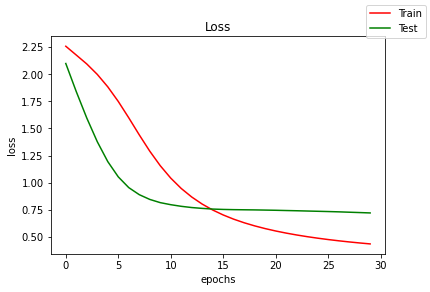

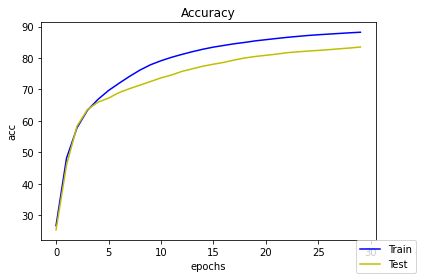

In [128]:
plot_results(loss_P2,acc_P2,loss_test_P2,acc_test_P2)

In [129]:
#prueba red normal con inicializacion de Xavier/He
acc_test_P2 = testear_FFNN(model_P2,test_dataset,batch_size=100,device="cuda")
print(acc_test_P2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


88.92999999999999


De los graficos y el resultado anterior podemos ver como si bien no obtenemos valores tan altos de acc en el train dataset como al no usar la incializacion, logramos muy buenos resultados en el test dataset y ademas en menos epocas. Obtenemos peores resultados en el train principalmente por esto ultimo, al hacer menos iteraciones al red no logra ajustarse tanto al train dataset, pero debemos destacar que aunque se este ajustando al train dataset, sigue sin perder la generalizacion al test dataset, esto debe ser debido a que al no incializar de forma random, no se "inclinan" tanto los parametros al train dataset.

Por estos resultados usaremos una red con esta incializacion frente para analizar los siguientes metodos. Pero si aumentamos las epocas, mejorar el aprendizaje?

In [130]:
#red normal con inicializacion de Xavier/He para varias epocas
F , C = 784 , 10
model_P2_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P2_e = SGD(list(model_P2_e.parameters()),lr=0.001,beta=0)
with torch.no_grad():
  loss_P2_e,acc_P2_e,loss_test_P2e,acc_test_P2e = entrenar_FFNN(model_P2_e,train_dataset,test_dataset,optimizer_P2_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:90.93% Loss:0.3187

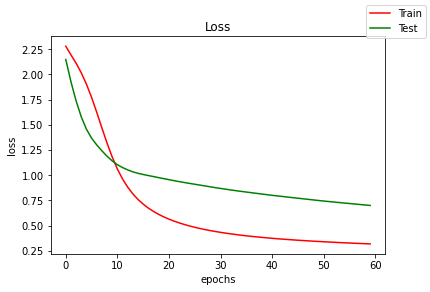

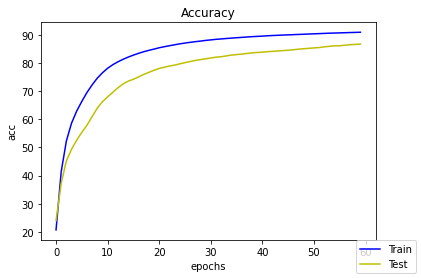

In [131]:
plot_results(loss_P2_e,acc_P2_e,loss_test_P2e,acc_test_P2e)

In [132]:
#prueba red normal con inicializacion de Xavier/He para varias epocas
acc_test_P2_e = testear_FFNN(model_P2_e,test_dataset,batch_size=100,device="cuda")
print(acc_test_P2_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


91.25


Como podemos ver, este si mejoro, no de forma tan brusca pero si mejoro, algo parecido a lo visto al aumentar las epocas de la red "normal".

Ahora se analizaran los resultados de entrenar la misma red usando DG con Momentum.

In [133]:
#red con inicializacion de Xavier/He usando DGM
F , C = 784 , 10
model_P22 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P22 = SGDM(list(model_P22.parameters()),lr=0.001,beta=0.0001,momentum=0.9)
with torch.no_grad():
  loss_P22,acc_P22,loss_test_P22,acc_test_P22 = entrenar_FFNN(model_P22,train_dataset,test_dataset,optimizer_P22,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:91.48% Loss:0.3374

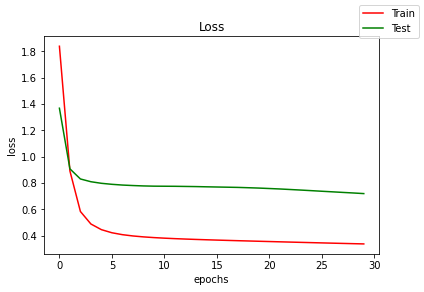

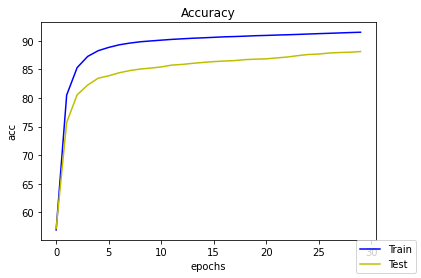

In [134]:
plot_results(loss_P22,acc_P22,loss_test_P22,acc_test_P22)

In [135]:
#prueba red con inicializacion de Xavier/He usando DGM
acc_test_P22 = testear_FFNN(model_P22,test_dataset,batch_size=100,device="cuda")
print(acc_test_P22)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


91.21000000000001


Podemos ver que hemos obtenido mejores que a los anteriores (red con inicializacion de Xavier/He en 60 epocas), y en la mitad de las epocas, esto se debe principalmente a que el SGDM tiene el objetivo de descender por el gradiente de una manera mas rapida que con un SGD normal, esto gracias a llevar una historia de los gradientes. Mejorar al aumentar las epocas?

In [151]:
#red con inicializacion de Xavier/He usando DGM para varias epocas
F , C = 784 , 10
model_P22_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P22_e = SGDM(list(model_P22_e.parameters()),lr=0.001,beta=0.0001,momentum=0.9)
with torch.no_grad():
  loss_P22_e,acc_P22_e,loss_test_P22e,acc_test_P22e = entrenar_FFNN(model_P22_e,train_dataset,test_dataset,optimizer_P22_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:92.54% Loss:0.3036

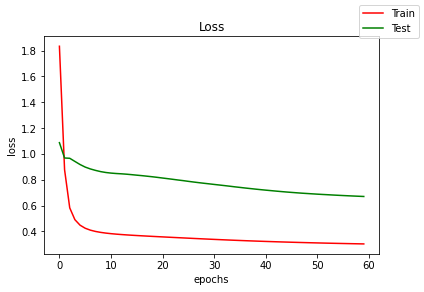

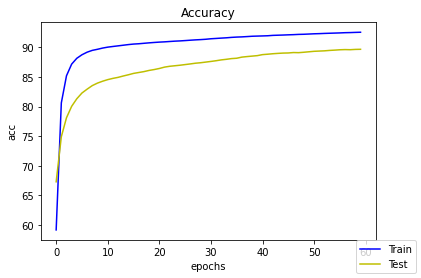

In [152]:
plot_results(loss_P22_e,acc_P22_e,loss_test_P22e,acc_test_P22e)

In [155]:
#prueba red con inicialiaziacion de Xavier/He usando DGM para varias epocas
acc_test_P22_e = testear_FFNN(model_P22_e,test_dataset,batch_size=100,device="cuda")
print(acc_test_P22_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


92.2


Como podemos ver en el grafico, el aprendizaje no mejora radicalmente, podemos suponer que es algo parecido que si hubieramos entrenado una red solo con inicializacion de Xavier/He pero en 120 epocas.

Ahora veremos los efectos de usar RMS Prop

In [139]:
#red con inicializacion de Xavier/He usando RMSP
F , C = 784 , 10
model_P23 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P23 = RMSProp(list(model_P23.parameters()),lr=0.001,beta=0.0001)
with torch.no_grad():
  loss_P23,acc_P23,loss_test_P23,acc_test_P23 = entrenar_FFNN(model_P23,train_dataset,test_dataset,optimizer_P23,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:99.44% Loss:0.0566

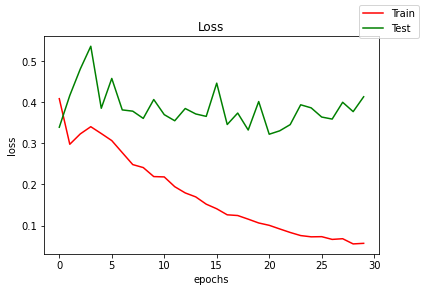

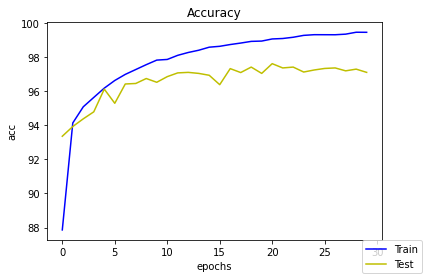

In [140]:
plot_results(loss_P23,acc_P23,loss_test_P23,acc_test_P23)

In [154]:
#prueba red con inicializacion de Xavier/He usando RMSP
acc_test_P23 = testear_FFNN(model_P23,test_dataset,batch_size=100,device="cuda")
print(acc_test_P23)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


97.13000000000001


De los graficos podemos ver que si bien no hemos mejorado enormemente la acc en el test dataset, hemos logrado reducir notablemente la loss, por lo que podriamos pensar en que nuestro modelo esta muchisimo mas cercano a la distribucion real de probabilidades que el anterior (aunque tengan la misma acc), esto se debe a que si bien estamos guardando una historia de los gradientes, lo estamos haciendo de otra forma, lo que provoca otros resultados que son a la vista mejores (por la disminucion de la loss). Que ocurrira si aumentamos las epocas?
Tambien otro punto es que si bien el grafico se ve un poco inestable, la principal razon de esto es la escala que tienen los graficos, en especial el de la loss, que contempla un rango muy pequeño de valores, lo que hace que cualquier pequeña variacion (que podria haber ocurrido antes) se vea como una gran oscilacion.

In [142]:
#red con inicializacion de Xavier/He usando RMSP para varias epocas
F , C = 784 , 10
model_P23_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P23_e = RMSProp(list(model_P23_e.parameters()),lr=0.001,beta=0.0001)
with torch.no_grad():
  loss_P23_e,acc_P23_e,loss_test_P23e,acc_test_P23e = entrenar_FFNN(model_P23_e,train_dataset,test_dataset,optimizer_P23_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:99.92% Loss:0.0083

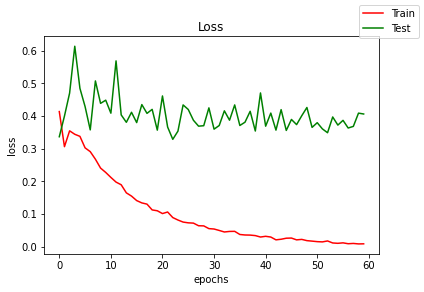

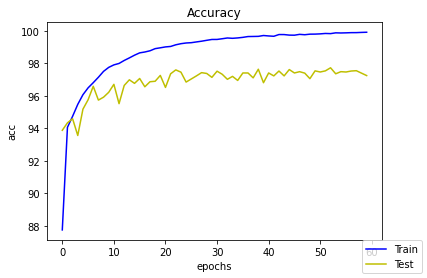

In [143]:
plot_results(loss_P23_e,acc_P23_e,loss_test_P23e,acc_test_P23e)

In [144]:
#prueba red con inicializacion de Xavier/He usando RMSP para varias epocas
acc_test_P23_e = testear_FFNN(model_P23_e,test_dataset,batch_size=100,device="cuda")
print(acc_test_P23_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


97.50999999999999


Podemos ver que nuestra intuicion estaba correcto, al darle mas tiempo de entrenamiento a la red (entrenarla por 60 epocas), hemos logrado un mejor aprendizaje llegando a valores de acc muy altos en el test dataset.

Finalmente analizaremos una red que utilice ADAM.

In [145]:
#red con inicializacion de Xavier/He usando ADAM
F , C = 784 , 10
model_P24 = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P24 = Adam(list(model_P24.parameters()),lr=0.001,beta1=0.9,beta2=0.999)
with torch.no_grad():
  loss_P24,acc_P24,loss_test_P24,acc_test_P24 = entrenar_FFNN(model_P24,train_dataset,test_dataset,optimizer_P24,epochs=30, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:030 Acc:99.88% Loss:0.0044

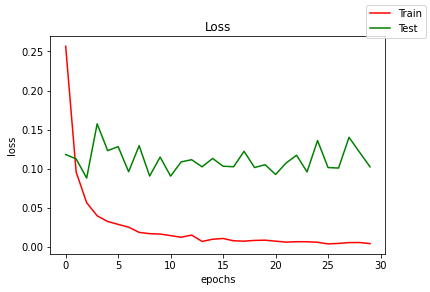

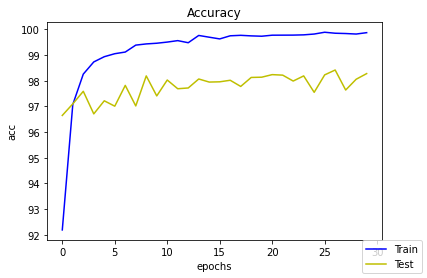

In [146]:
plot_results(loss_P24,acc_P24,loss_test_P24,acc_test_P24)

In [147]:
#prueba red con inicializacion de Xavier/He usando ADAM
acc_test_P24 = testear_FFNN(model_P24,test_dataset,batch_size=100,device="cuda")
print(acc_test_P24)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


98.38


De los resultados anteriores podemos ver como Adam aplasto totalmente a los otros metodos, logrando niveles muy altos de acc y muy bajos de loss tanto en el train dataset como en el test dataset, ademas de logralo en muy pocas epocas (en la mayoria del grafico se puede ver que los valores mejoran mucho al principio pero que rapidamente se estabilizan y permancen practicamente constantes). Podremos mejorar aun mas este resultado al usar mas epocas?

In [148]:
#red normal con inicializacion de Xavier/He usando ADAM para varias epocas
F , C = 784 , 10
model_P24_e = FFNN(F,[1024,1024,350],[relu,sig,relu],C,keep_prob=[1,1,1,1],inicializacion=True)
optimizer_P24_e = Adam(list(model_P24_e.parameters()),lr=0.001,beta1=0.9,beta2=0.999)
with torch.no_grad():
  loss_P24_e,acc_P24_e,loss_test_P24e,acc_test_P24e = entrenar_FFNN(model_P24_e,train_dataset,test_dataset,optimizer_P24_e,epochs=60, batch_size=100, device='cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:060 Acc:99.90% Loss:0.0041

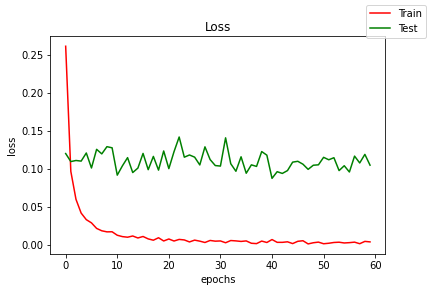

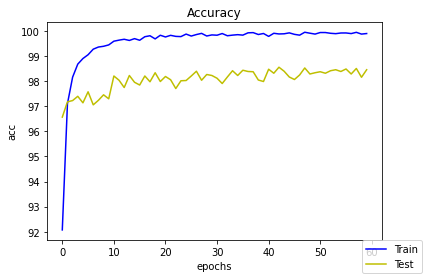

In [149]:
plot_results(loss_P24_e,acc_P24_e,loss_test_P24e,acc_test_P24e)

In [150]:
#prueba red normal con inicializacion de Xavier/He usando DGM para varias epocas
acc_test_P24_e = testear_FFNN(model_P24_e,test_dataset,batch_size=100,device="cuda")
print(acc_test_P24_e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


98.44000000000001


Como podemos ver en los graficos este resultado no mejoro practicamente nada, esto era de esperarse pues se pudo notar en el grafico anterior como este no variaba mucho a partir desde la decima epoca, por lo que podiamos suponer que este no variaria mas.

A modo de conclusion, podemos ver que:

Los resultados obtenidos en el train dataset no son del todo ciertos en la mayoria de los casos, pues puede que nuestra red se sobreajuste a estos datos y pierda generalizacion, lo que hace vital el tener un test dataset para poder medir realmente que tan bien lo hace nuestro modelo

Tambien pudimos ver lo util que es el usar regularizacion al momento de entrenar una red, pues de esta forma logramos que nuestra red logre mejores valores al momento de querer generalizar y usar ejemplos que no fueron vistos en el entrenamiento (que es lo mas cercano a la realidad)

Otra cosa que pudimos ver es lo utiles que pueden ser las tecnicas de optimizacion, pues de esta forma logramos obtener resultados por mucho mejores a los que obteniamos al usar una inicializacion random o al usar SGD

# Parte 3 (Opcional): Batch Normalization

In [ ]:
# Tu código debiera continuar como sigue

class FFNN():
  def __init__(self, F, l_h, l_a, C, keep_prob=None, bn=None):
    # debes crear los parámetros necesarios para las capas de
    # batch normalizacion
    pass
  
  def forward(x, predict=False):
    # debes modificar esta función para considerar las capas para las que se
    # usará batch normalization
    # también debes preocuparte de guardar los datos estadísticos que se
    # usaran en tiempo de test (predict=True)
    pass
  
  def backward(x,y,y_pred):
    # computar acá todos los gradientes considerando las capas de 
    # batch normalization
    # no olvides considerar los nuevos parámetros entrenables.
    pass